# Predict Insample
> Tutorial on how to produce insample predictions.

This tutorial provides and example on how to use the `predict_insample` function of the `core` class to produce forecasts of the train and validation sets. In this example we will train the `NHITS` model on the AirPassengers data, and show how to recover the insample predictions after model is fitted.

*Predict Insample*: The process of producing forecasts of the train and validation sets.

*Use Cases*: 
* Debugging: producing insample predictions is useful for debugging purposes. For example, to check if the model is able to fit the train set.
* Training convergence: check if the the model has converged.
* Anomaly detection: insample predictions can be used to detect anomalous behavior in the train set (e.g. outliers). (Note: if a model is too flexible it might be able to perfectly forecast outliers)

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/PredictInsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

## 2. Loading AirPassengers Data

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']`, where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target variable. 

In this example dataset consists of a set of a single series, but you can easily fit your model to larger datasets in long format.

In [ ]:
from neuralforecast.utils import AirPassengersDF

In [ ]:
Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## 3. Model Training

First, we train the `NHITS` models on the AirPassengers data. We will use the `fit` method of the `core` class to train the models.

In [ ]:
import logging
import pandas as pd

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [ ]:
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [NHITS(h=horizon,                      # Forecast horizon
                input_size=2 * horizon,         # Length of input sequence
                max_steps=100,                  # Number of steps to train
                n_freq_downsample=[2, 1, 1],    # Downsampling factors for each stack output
                mlp_units = 3 * [[1024, 1024]],
               ) # Number of units in each block.
          ]
nf = NeuralForecast(models=models, freq='ME')
nf.fit(df=Y_df, val_size=horizon)

Seed set to 1


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

## 4. Predict Insample

Using the `NeuralForecast.predict_insample` method you can obtain the forecasts for the train and validation sets after the models are fitted. The function will always take the last dataset used for training in either the `fit` or `cross_validation` methods.

With the `step_size` parameter you can specify the step size between consecutive windows to produce the forecasts. In this example we will set `step_size=horizon` to produce non-overlapping forecasts.

The following diagram shows how the forecasts are produced based on the `step_size` parameter and `h` (horizon) of the model. In the diagram we set `step_size=2` and `h=4`.

![](../imgs_indx/predict_insample.png)

In [ ]:
Y_hat_insample = nf.predict_insample(step_size=horizon)

Predicting: |                                                                                                 …

The `predict_insample` function returns a pandas DataFrame with the following columns:
* `unique_id`: the unique identifier of the time series.
* `ds`: the datestamp of the forecast for each row.
* `cutoff`: the datestamp at which the forecast was made.
* `y`: the actual value of the target variable.
* `model_name`: the forecasted values for the models. In this case, `NHITS`. 

In [ ]:
Y_hat_insample.head()

,unique_id,ds,cutoff,NHITS,y
0,1.0,1949-01-31,1948-12-31,0.057849,112.0
1,1.0,1949-02-28,1948-12-31,0.061673,118.0
2,1.0,1949-03-31,1948-12-31,0.044137,132.0
3,1.0,1949-04-30,1948-12-31,0.121791,129.0
4,1.0,1949-05-31,1948-12-31,0.135417,121.0


:::{.callout-important}
The function will produce forecasts from the first timestamp of the time series. For these initial timestamps, the forecasts might not be accurate given that models have very limited input information to produce forecasts.
:::

## 5. Plot Predictions

Finally, we plot the forecasts for the train and validation sets.

In [ ]:
from utilsforecast.plotting import plot_series

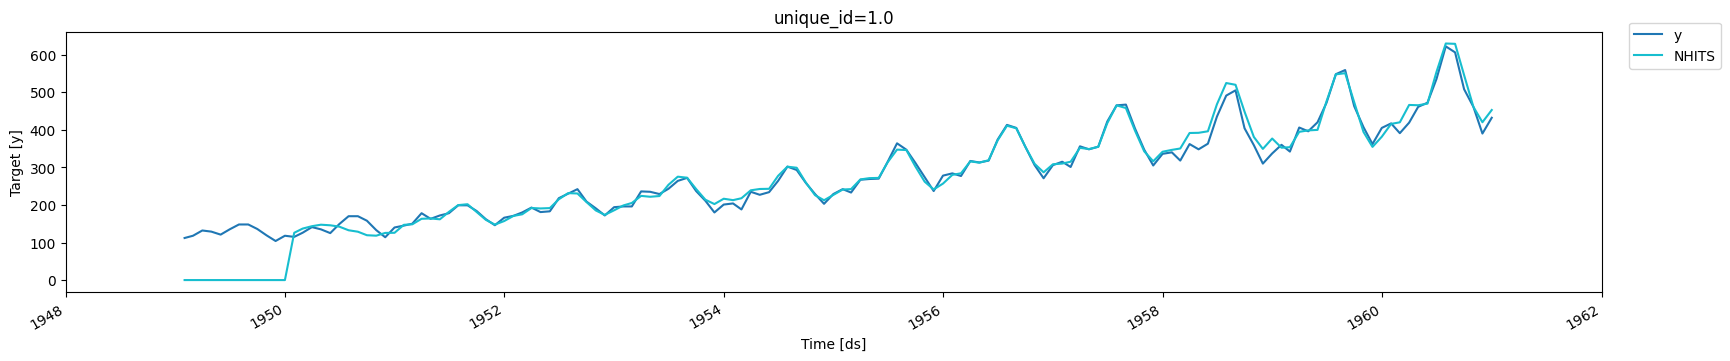

In [ ]:
plot_series(forecasts_df=Y_hat_insample.drop(columns='cutoff'))

## References
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)